# Battle of Neighbourhoods - Week 1


# Part 1: A description of the problem and a discussion of the background

> ### 1.1 Description of the Problem

The population of Italy has grown considerably over the last decades. Italy is very diverse. In Africa you can get variety of fresh food from supplies from Africa.
 
There are many fine restaurants in Africa – Asian, Middle Eastern, Latin and American restaurants, it is hard to find a good place to dine in.


> ### 1.2 Discussion of the Background

My client is a successful restaurant chain in Ghana; he is looking to expand operation into EUROP starting in Italy. His target is luxury restaurant
Since Italy demography has many Regions, My client needs deeper insight from available data in other to decide where to establish first. This company spends a lot on research and provides customers with data insight into the ingredients used at restaurants.


# Part 2 - A description of the data and how it will be used to solve the problem

> ### 2.1 Description of Data


Data will be from public data, Wikipedia and Foursquare.

Italy Area consists of many regions which has some specific popular areas < https://en.wikipedia.org/wiki/List_of_cities_in_Italy >

#### A sample of the web scrapped of the Wikipedia page 

In [25]:
from bs4 import BeautifulSoup


import numpy as np


import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import json
print('numpy, pandas, ..., imported...')

!pip -q install geopy

print('geopy installed...')

from geopy.geocoders import Nominatim
print('Nominatim imported...')


import requests
print('requests imported...')


from pandas.io.json import json_normalize
print('json_normalize imported...')


import matplotlib.cm as cm
import matplotlib.colors as colors
print('matplotlib imported...')


from sklearn.cluster import KMeans
print('Kmeans imported...')


!pip -q install geocoder
import geocoder


import time


!pip -q install folium
print('folium installed...')
import folium # map rendering library
print('folium imported...')
print('...Done')

numpy, pandas, ..., imported...
geopy installed...
Nominatim imported...
requests imported...
json_normalize imported...
matplotlib imported...
Kmeans imported...
folium installed...
folium imported...
...Done


In [26]:
wikipedia_link = 'https://en.wikipedia.org/wiki/List_of_cities_in_Italy'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
wikipedia_page = requests.get(wikipedia_link, headers = headers)
wikipedia_page

<Response [200]>

In [27]:
soup = BeautifulSoup(wikipedia_page.content, 'html.parser')
table = soup.find('table', {'class':'wikitable sortable'}).tbody
rows = table.find_all('tr')
columns = [i.text.replace('\n', '')
           for i in rows[0].find_all('th')]
df = pd.DataFrame(columns = columns)
df

,Rank,City,2011 Census,2017 Estimate,Change,Region


In [28]:
for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    
    
    if len(tds) == 7:
        values = [tds[0].text, tds[1].text, tds[2].text.replace('\n', ''.replace('\xa0','')), tds[3].text, tds[4].text.replace('\n', ''.replace('\xa0','')), tds[5].text.replace('\n', ''.replace('\xa0','')), tds[6].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values = [td.text.replace('\n', '').replace('\xa0','') for td in tds]
        
        df = df.append(pd.Series(values, index = columns), ignore_index = True)

        df

In [29]:
df.head(5)

,Rank,City,2011 Census,2017 Estimate,Change,Region
0,1,Rome,"2,617,175","2,872,800",+9.77%,Lazio
1,2,Milan,"1,242,123","1,366,180",+9.99%,Lombardy
2,3,Naples,"962,003","966,144",+0.43%,Campania
3,4,Turin,"872,367","882,523",+1.16%,Piedmont
4,5,Palermo,"657,651","668,405",+1.64%,Sicily


In [30]:
df['City'] = df['City'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

In [31]:
df0 = df.drop('City', axis=1).join(df['City'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('City'))

In [32]:
df1 = df0[['Rank', 'City', 'Region']].reset_index(drop=True)

In [33]:
df1.head(5)

,Rank,City,Region
0,1,Rome,Lazio
1,2,Milan,Lombardy
2,3,Naples,Campania
3,4,Turin,Piedmont
4,5,Palermo,Sicily


In [34]:
df2 = df1

In [35]:
df21 = df2[df2['Region'].str.contains('Lazio')]

In [36]:
df21.head(10)

,Rank,City,Region
0,1,Rome,Lazio
31,32,Latina,Lazio
57,58,Guidonia Montecelio,Lazio
69,70,Fiumicino,Lazio
75,76,Aprilia,Lazio
87,88,Viterbo,Lazio
94,95,Pomezia,Lazio
114,115,Tivoli,Lazio
120,121,Anzio,Lazio
129,130,Velletri,Lazio


In [37]:
df3 = df21[['Rank', 'City', 'Region']].reset_index(drop=True)

In [38]:
df_Lazio = df3

In [39]:
df21.shape

(11, 3)

### 2.1.2 Dataset 2:

In obtaining the location data of the locations, the Geocoder package is used with the arcgis_geocoder to obtain the latitude and longitude of the needed locations.

In [40]:
'''Geocoder starts here'''
'''Defining a function to use --> get_latlng()'''
def get_latlng(arcgis_geocoder):
    
   
    lat_lng_coords = None
    
   
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Lazio, Italy'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords
'''Geocoder ends here'''

'Geocoder ends here'

In [41]:
City_codes = df['City']    
coordinates = [get_latlng(City_code) for City_code in City_codes.tolist()]

In [42]:
df_Lazio_loc = df_Lazio

df_Lazio_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_Lazio_loc['Latitude'] = df_Lazio_coordinates['Latitude']
df_Lazio_loc['Longitude'] = df_Lazio_coordinates['Longitude']

## Testing Sample for Rome

In [43]:
sample = get_latlng('Rome')
sample

[41.90322000000003, 12.495650000000069]

## Reverse geocoding this, using the geocodefarm geocoder, gives the following:

In [44]:
gg = geocoder.geocodefarm(sample, method = 'reverse')
gg

<[OK] Geocodefarm - Reverse [Via Vittorio Emanuele Orlando 70, 00185 Rome Rome, Italy]>

## Applying the function to find Latitude and Longitude

In [45]:
start = time.time()

City_codes = df_Lazio['Region']    
coordinates = [get_latlng(City_code) for City_code in City_codes.tolist()]

end = time.time()
print("Time of execution: ", end - start, "seconds")

Time of execution:  7.308433532714844 seconds


## Then we proceed to store the location data - latitude and longitude as follows. 

In [46]:
df_se_loc = df_Lazio


df_se_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_se_loc['Latitude'] = df_se_coordinates['Latitude']
df_se_loc['Longitude'] = df_se_coordinates['Longitude']

In [47]:
df_Lazio_loc.head()

,Rank,City,Region,Latitude,Longitude
0,1,Rome,Lazio,41.975682,12.772626
1,32,Latina,Lazio,41.975682,12.772626
2,58,Guidonia Montecelio,Lazio,41.975682,12.772626
3,70,Fiumicino,Lazio,41.975682,12.772626
4,76,Aprilia,Lazio,41.975682,12.772626


In [49]:
df_Lazio_loc.to_csv('SELazioLocationsCoordinates.csv', index = False)

# 3 Methodology

This section represents the main component of the report where the data is gathered, prepared for analysis. The tools described are used here and the Notebook cells indicates the execution of steps.

### 3.1 Data Exploration


#### 3.1.1 Single Neighbourhood

In [50]:
La_df = df_Lazio_loc.reset_index().drop('index', axis = 1)

In [51]:
La_df.shape

(11, 5)

In [52]:
La_df

,Rank,City,Region,Latitude,Longitude
0,1,Rome,Lazio,41.975682,12.772626
1,32,Latina,Lazio,41.975682,12.772626
2,58,Guidonia Montecelio,Lazio,41.975682,12.772626
3,70,Fiumicino,Lazio,41.975682,12.772626
4,76,Aprilia,Lazio,41.975682,12.772626
5,88,Viterbo,Lazio,41.975682,12.772626
6,95,Pomezia,Lazio,41.975682,12.772626
7,115,Tivoli,Lazio,41.975682,12.772626
8,121,Anzio,Lazio,41.975682,12.772626
9,130,Velletri,Lazio,41.975682,12.772626


In [53]:
La_df.loc[La_df['City'] == 'Rome']

,Rank,City,Region,Latitude,Longitude
0,1,Rome,Lazio,41.975682,12.772626


Let's use Rome with the index location 0.

In [54]:
La_df.loc[0, 'City']

'Rome'

In [55]:
Rome_lat = La_df.loc[0, 'Latitude']
Rome_long = La_df.loc[0, 'Longitude']
Rome_Cit = La_df.loc[0, 'City']
Rome_Region = La_df.loc[0, 'Region']

print('The latitude and longitude values of {} with Region {}, are {}, {}.'.format(Rome_Cit,
                                                                                         Rome_Region,
                                                                                         Rome_lat,
                                                                                       Rome_long))

The latitude and longitude values of Rome with Region Lazio, are 41.975681888000054, 12.772626325000033.


### METHODOLOY EXECUTION - Mapping Data

In [56]:
import json
print('numpy, pandas, ..., imported...')

from pandas.io.json import json_normalize
print('json_normalize imported...')



numpy, pandas, ..., imported...
json_normalize imported...


In [57]:
address = 'Lazio, Italy'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Italy home are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Italy home are 41.9808038, 12.7662312.


In [58]:
neighborhood_latitude=41.9808038
neighborhood_longitude=12.7662312

explore the top 100 venues that are within a 2000 metres radius of Lazio.
And then, let's create the GET request URL, and then the url is named.

In [59]:
CLIENT_ID = 'FL1GDNSXKBRH2XQ4KIZP2ACOZQ0TQRG0LVFZZNJSY4BTA452'
CLIENT_SECRET = 'YPV5PQBM5G4KSKXKY2XGRSIFM4O2V5N1LKALCGIMFDTZYAD0' 
VERSION = '20190416'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FL1GDNSXKBRH2XQ4KIZP2ACOZQ0TQRG0LVFZZNJSY4BTA452
CLIENT_SECRET:YPV5PQBM5G4KSKXKY2XGRSIFM4O2V5N1LKALCGIMFDTZYAD0


In [62]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Rome_lat, 
    Rome_long, 
    radius, 
    LIMIT)

# displays URL
url

'https://api.foursquare.com/v2/venues/explore?&client_id=FL1GDNSXKBRH2XQ4KIZP2ACOZQ0TQRG0LVFZZNJSY4BTA452&client_secret=YPV5PQBM5G4KSKXKY2XGRSIFM4O2V5N1LKALCGIMFDTZYAD0&v=20190416&ll=41.975681888000054,12.772626325000033&radius=2000&limit=100'

In [63]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5cb6b1216a60715adbc3cbb3'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4f850f3ae4b0ae40e13808f9-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
          'suffix': '.png'},
         'id': '52f2ab2ebcbc57f1066b8b46',
         'name': 'Supermarket',
         'pluralName': 'Supermarkets',
         'primary': True,
         'shortName': 'Supermarket'}],
       'id': '4f850f3ae4b0ae40e13808f9',
       'location': {'address': 'Via Tiburtina',
        'cc': 'IT',
        'city': 'Villanova',
        'country': 'Italia',
        'distance': 1521,
        'formattedAddress': ['Via Tiburtina', 'Villanova Lazio', 'Italia'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 41.96785784723111,
          'l

From the results, the necessary information needs to be obtained from items key. To do this, the get_category_type function is used from the Foursquare lab.

In [64]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### The result is then cleaned up from json to a structured pandas dataframe as shown below:

In [65]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) 


filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]


nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)


nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [66]:
nearby_venues

,name,categories,lat,lng
0,Carrefour Market,Supermarket,41.967858,12.757551
1,villa ulpia,Italian Restaurant,41.974702,12.782430
2,Spiridigliozzi,Construction & Landscaping,41.972340,12.750160
3,piazza villanova,Plaza,41.963789,12.755968


In [67]:
nearby_venues_Rome_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')

In [68]:
nearby_venues_Rome_unique.head(5)

,Count
Italian Restaurant,1
Construction & Landscaping,1
Plaza,1
Supermarket,1


Interestingly, even though there are restaurants are the Rome area, they are not even in the top 5 venues. It should be noted that since we are limited by data availability, our perspectives will be on what we have.

In [69]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


### 3.1.2 Multiple Neighbourhoods

explore (Multiple) Neighborhoods in Rome City

In [70]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [71]:
La_venues = getNearbyVenues(names=La_df['City'],
                                   latitudes=La_df['Latitude'],
                                   longitudes=La_df['Longitude']
                                  )

Rome
Latina
Guidonia Montecelio
Fiumicino
Aprilia
Viterbo
Pomezia
Tivoli
Anzio
Velletri
Civitavecchia


In [72]:
La_venues.shape

(44, 7)

In [73]:
len(La_venues)

44

In [74]:
La_venues['Neighbourhood'].value_counts()
La_venues.to_csv('La_venues.csv')

In [75]:
La_venues.head(5)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rome,41.975682,12.772626,Carrefour Market,41.967858,12.757551,Supermarket
1,Rome,41.975682,12.772626,villa ulpia,41.974702,12.782430,Italian Restaurant
2,Rome,41.975682,12.772626,Spiridigliozzi,41.972340,12.750160,Construction & Landscaping
3,Rome,41.975682,12.772626,piazza villanova,41.963789,12.755968,Plaza
4,Latina,41.975682,12.772626,Carrefour Market,41.967858,12.757551,Supermarket


#### The number of venues returned for each neighbourhoods is then explored as follows:

In [76]:
La_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Anzio,4,4,4,4,4,4
Aprilia,4,4,4,4,4,4
Civitavecchia,4,4,4,4,4,4
Fiumicino,4,4,4,4,4,4
Guidonia Montecelio,4,4,4,4,4,4
Latina,4,4,4,4,4,4
Pomezia,4,4,4,4,4,4
Rome,4,4,4,4,4,4
Tivoli,4,4,4,4,4,4


The next step is to check how many unique categories can be returned for the venues. See as follows:

In [77]:
print('There are {} uniques categories.'.format(len(La_venues['Venue Category'].unique())))

There are 4 uniques categories.


In [78]:
La_venue_unique_count = La_venues['Venue Category'].value_counts().to_frame(name='Count')

In [79]:
La_venue_unique_count.head(5)

,Count
Italian Restaurant,11
Construction & Landscaping,11
Plaza,11
Supermarket,11


In [80]:
La_venue_unique_count.describe()

,Count
count,4.0
mean,11.0
std,0.0
min,11.0
25%,11.0
50%,11.0
75%,11.0
max,11.0


### 3.2 Clustering 

 clustered based on the processed data obtained above.

#### 3.2.1 Libraries

All the necessary libraries have been called in the libraries section above.

#### 3.2.2 Map Visualization

In [82]:
address = 'Lazio, Italy'

geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Lazio are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Lazio are 41.9808038, 12.7662312.


In [83]:
map_Lazio = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_Lazio

In [89]:

# Adding markers to map
for lat, lng, City, loc in zip(La_df['Latitude'], 
                                  La_df['Longitude'],
                                  La_df['City'],
                                  La_df['Region']):
    label = '{} - {}'.format(loc, City)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_Lazio)  
    
display(map_Lazio)

In [90]:
type(La_df)

pandas.core.frame.DataFrame

### 3.2.3 Analysing Each Neighborhood

In this section, the objective is to check and explore the venues in each neighbourhood.

### One Hot Encoding

In [92]:
La_onehot = pd.get_dummies(La_venues[['Venue Category']], prefix = "", prefix_sep = "")
La_onehot['Neighbourhood'] = La_venues['Neighbourhood']
fixed_columns = [La_onehot.columns[-1]] + list(La_onehot.columns[:-1])
La_onehot = La_onehot[fixed_columns]

In [97]:
La_onehot.head(5)

,Neighbourhood,Construction & Landscaping,Italian Restaurant,Plaza,Supermarket
0,Rome,0,0,0,1
1,Rome,0,1,0,0
2,Rome,1,0,0,0
3,Rome,0,0,1,0
4,Latina,0,0,0,1


In [101]:
La_onehot.loc[La_onehot['Plaza'] != 0]

,Neighbourhood,Construction & Landscaping,Italian Restaurant,Plaza,Supermarket
3,Rome,0,0,1,0
7,Latina,0,0,1,0
11,Guidonia Montecelio,0,0,1,0
15,Fiumicino,0,0,1,0
19,Aprilia,0,0,1,0
23,Viterbo,0,0,1,0
27,Pomezia,0,0,1,0
31,Tivoli,0,0,1,0
35,Anzio,0,0,1,0
39,Velletri,0,0,1,0


In [102]:
La_onehot.loc[La_onehot['Neighbourhood'] == 'Rome']

,Neighbourhood,Construction & Landscaping,Italian Restaurant,Plaza,Supermarket
0,Rome,0,0,0,1
1,Rome,0,1,0,0
2,Rome,1,0,0,0
3,Rome,0,0,1,0


### Regrouping and Category Statistics

In [103]:
La_grouped = La_onehot.groupby('Neighbourhood').mean().reset_index()
La_grouped.head()

,Neighbourhood,Construction & Landscaping,Italian Restaurant,Plaza,Supermarket
0,Anzio,0.25,0.25,0.25,0.25
1,Aprilia,0.25,0.25,0.25,0.25
2,Civitavecchia,0.25,0.25,0.25,0.25
3,Fiumicino,0.25,0.25,0.25,0.25
4,Guidonia Montecelio,0.25,0.25,0.25,0.25


In [104]:
print("Before One-hot encoding:", La_df.shape)
print("After One-hot encoding:", La_grouped.shape)

Before One-hot encoding: (11, 5)
After One-hot encoding: (11, 5)


In [105]:

La_grouped.to_csv('lazio_grouped.csv', index = False)

##### Grouping of each Neighbourhoods with 10 common venues:

In [122]:
num_top_venues = 10 
for hood in La_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = La_grouped[La_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Anzio----
                        venue  freq
0  Construction & Landscaping  0.25
1          Italian Restaurant  0.25
2                       Plaza  0.25
3                 Supermarket  0.25


----Aprilia----
                        venue  freq
0  Construction & Landscaping  0.25
1          Italian Restaurant  0.25
2                       Plaza  0.25
3                 Supermarket  0.25


----Civitavecchia----
                        venue  freq
0  Construction & Landscaping  0.25
1          Italian Restaurant  0.25
2                       Plaza  0.25
3                 Supermarket  0.25


----Fiumicino----
                        venue  freq
0  Construction & Landscaping  0.25
1          Italian Restaurant  0.25
2                       Plaza  0.25
3                 Supermarket  0.25


----Guidonia Montecelio----
                        venue  freq
0  Construction & Landscaping  0.25
1          Italian Restaurant  0.25
2                       Plaza  0.25
3                 Supermarket 

In [124]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [127]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = La_grouped['Neighbourhood']

for ind in np.arange(La_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(La_grouped.iloc[ind, :], num_top_venues)

In [128]:

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Anzio,Supermarket,Plaza,Italian Restaurant
1,Aprilia,Supermarket,Plaza,Italian Restaurant
2,Civitavecchia,Supermarket,Plaza,Italian Restaurant
3,Fiumicino,Supermarket,Plaza,Italian Restaurant
4,Guidonia Montecelio,Supermarket,Plaza,Italian Restaurant


In [129]:
neighbourhoods_venues_sorted.to_csv('neighbourhoods_venues_sorted.csv', index = False)

In [130]:

La_grouped_clustering = La_grouped.drop('Neighbourhood', 1)

### 3.2 Clustering of Neighbourhoods

In [131]:
kclusters = 5


kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(La_grouped_clustering)


kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [132]:
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [133]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [146]:
Se_merged = La_df

In [147]:
Se_merged.head(3)

,Rank,City,Region,Latitude,Longitude
0,1,Rome,Lazio,41.975682,12.772626
1,32,Latina,Lazio,41.975682,12.772626
2,58,Guidonia Montecelio,Lazio,41.975682,12.772626


In [155]:
Se_merged_latlong = Se_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'City')

In [158]:
Se_merged_latlong.head(5)

,Rank,City,Region,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,1,Rome,Lazio,41.975682,12.772626,0,Supermarket,Plaza,Italian Restaurant
1,32,Latina,Lazio,41.975682,12.772626,0,Supermarket,Plaza,Italian Restaurant
2,58,Guidonia Montecelio,Lazio,41.975682,12.772626,0,Supermarket,Plaza,Italian Restaurant
3,70,Fiumicino,Lazio,41.975682,12.772626,0,Supermarket,Plaza,Italian Restaurant
4,76,Aprilia,Lazio,41.975682,12.772626,0,Supermarket,Plaza,Italian Restaurant


In [161]:
se_clusters = La_merged_latlong

##### 3.2. Optimal Number of Clusters for K-mean

##### 1. Elbow Method

In [162]:
%matplotlib inline
import matplotlib
import numpy as np

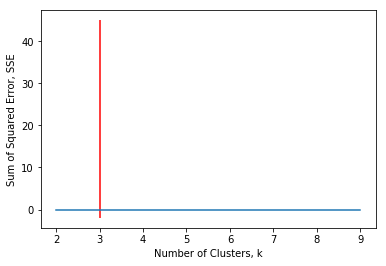

In [163]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


sse = {}
for n_cluster1 in range(2, 10):
    kmeans1 = KMeans(n_clusters = n_cluster1, max_iter = 500).fit(La_grouped_clustering)
    La_grouped_clustering["clusters"] = kmeans1.labels_
    
   
    sse[n_cluster1] = kmeans1.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters, k")
plt.ylabel("Sum of Squared Error, SSE")

plt.vlines(3, ymin = -2, ymax = 45, colors = 'red')
plt.show()

### 4. Result

African Resturant very rarely to find, he will successd 

### 5. Discussion and Conclusion

In conclusion, this project would have had better results if there were more data in terms of crime data within the area, allowance of more venues exploration with the Foursquare 